# Traffic Data Analysis in Hefei, China

China had a rapid development in the recent years, especially on cars. The number of cars grows 10 times in the recent decade. As a result of the growth, more and more traffic is bothering people who need to drive every day. Particularly before and after work in every weekdays, many cars are stuck in traffic jams. And if there is a bad weather, situations gets much worse. The traffic condition throughout a day changes drastically, base on different reasons - driving to work, picking up kids, weather, etc.



People cannot live without vehicles. Going to work, going to and off school, visiting different places, and so on. However, as we see nowadays, as more vehicles are been produced and get onto roads, traffic on the road is getting worse and worse day by day. The impact of traffic jam will obviously been noticebly amplified if you are living in a big city in China. In China, cities has a much higher population density, with a lot of cars crowded in a relatively small area. The way people drive daily is different from that in California - instead of speeding up on freeways, many people need to get into the slowly moving traffic, every working days. The situation is getting worse with a rapid growing number of cars people own, which increased 10 times in the past decade. The traffic condition thoughout a day changes drastically, base on different reasons - driving to work, picking up kids, weather, etc.

In this project, I had a Python script I wrote at the beginning of 2018 running on a server collecting real-time traffic information from four representative locations using AMaps API. (AMap is of the largest map providers in China, like Google Maps in the US). The four locations are:
- `Zhanqian Rd`  (Near train station, doesn't have much going-to-work traffic as compared to others)
- `Huizhou Ave (Dazhonglou)` (One of the busiest road that goes through city central)
- `Ningguo Rd (near South 1st Ring Rd.)`   (One of the busiest road goes around the city)
- `Xiyou Rd`  (Near a major highschool, big shopping malls nearby)

The API gives the following data:
- expedite % (vehicles move normally)
- congestion % (vehicles move slowly)
- block % (vehicles rarely move)
- unknown % (data unknown)

Those data are saved into a csv file for later analysis use, and also published to thingspeak for a direct visualization in real time (https://thingspeak.com/channels/399882)

In this jupyter notebook, the saved csv containing data from the beginning of the year to October is loaded using `pandas`, and after some manupulation, created visualizations with `seaborn`.

In [65]:
from processing.load_data import load_dataset, load_rain_data
from processing.plot import *
import matplotlib.pyplot as plt
import os

# Matplotlib plotting setting
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=30)  # fontsize of the axes title
plt.rc('axes', labelsize=30)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=40)  # fontsize of the figure title
#coding:utf-8
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

zhanqian = load_dataset(os.getcwd() + '/data/zhanqian.csv')
huizhou = load_dataset(os.getcwd() + '/data/zhonglou.csv')
ningguo = load_dataset(os.getcwd() + '/data/ningguo.csv')
xiyou = load_dataset(os.getcwd() + '/data/xiyou.csv')

## Per 10 minute average congestion plot
First, we took the average for every 10 minute of the day and made a line plot. It is also important to `separate` weekday data and weekend data since there is no rushing hours to go to work during weekends.

Since `Zhanqian Rd` is an exception, being near the train station makes it much more affected by train schedule then work rush hours, we will discuss this exception later. 

The first obvious thing coming out of these plots are the rushing hour going to and off work from 7am-9am, and 5pm-7pm. For weekdays (blue) there is a clear peak on the other three locations. However on weekends (green), the morning working rush hours is clearly gone. People tend to "wake up" later at around 10am-12am and go out. There is a valley at around 12:30pm-1:30pm, possibly because people are having their noon nap.

As mentioned before, block means super heavy traffic, which cause vehicles to merely move. For the block ratio, we can also observe peaks on the work rushing hours in the morning and evening, however on weekends, these peaks are gone for the morning rushing hours. The evening peak is still there possibly because of people going out to eat. Another peak is around 10am-12am with possibly the same reason - people going to eat brunch / lunch. 

Comparing workdays and weekends, we can also observe that Xiyou Rd has a much higher traffic difference as compared to other places during weekends, possibly because of the big shopping malls nearby. Similarly, Ningguo Rd, having some restaurants nearby, has more traffic than Huizhou Ave over weekends.

For `Zhanqian Rd`, apart from the absense of rushing hours going on and off work, we can generally observe that at day time more congestion is there generally. Since it is close to the train station, it is expected there to be more train leaving and arriving during day time. There is a peak at 6pm for possibly dinner (since it's roughly the same for weekdays and nonweekdays) Interestingly, during weekdays there are less traffic than usual at 7:20am in the morning, however weekends looks normal. Possible reason is that people don't want to take the train during that time, since they don't want to hit the bad traffic on their way to train station.

In [143]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%h')

def weekday_weekend_ten_min_plot(df, ax, title):
    """
    Make a per 10 min average plot for traffic congestion and block %, for weekdays and weekends
    :param DataFrame df: Traffic DataFrame used to plot
    :param plt.axis ax: Matplotlib axis to plot on
    :param str title: Title for the plot
    """

    def process_average(df):
        """
        Calculate per 10 minute average for every date
        :param df: Traffic DataFrame used to calculate
        :return: DataFrame containing the calculate per 10 minute data
        """
        avg = df.groupby([df.index.hour, df.index.minute]).mean()
        avg.index = avg.index.map('{0[0]}:{0[1]}'.format)
        avg.index = pd.to_datetime(avg.index, format='%H:%M').time
        return avg

    weekday = df[df.index.dayofweek < 5]
    weekend = df[df.index.dayofweek >= 5]
    avg_weekday = process_average(weekday)[['congestion', 'heavy_congestion']].rename({'congestion': '工作日不畅率',
                                                                            'heavy_congestion': '工作日严重拥堵率'}, axis=1)
    avg_weekend = process_average(weekend)[['congestion', 'heavy_congestion']].rename({'congestion': '周末不畅率',
                                                                            'heavy_congestion': '周末严重拥堵率'}, axis=1)
    plot_df = pd.concat([avg_weekday, avg_weekend], axis=1)
    sns.lineplot(data=plot_df, ax=ax)
    ax.set_xlim('00:00', '23:50')
    ax.set_ylim(0, 0.7)
    ax.set_xlabel('时间')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=40)
    ax.set_xticks([f'{hr}:00' for hr in range(0, 24, 2)]);
#     ax.xaxis.set_major_formatter(myFmt)
    ax.set_title(title)
    ax.legend(loc='upper left')
    ax.grid()

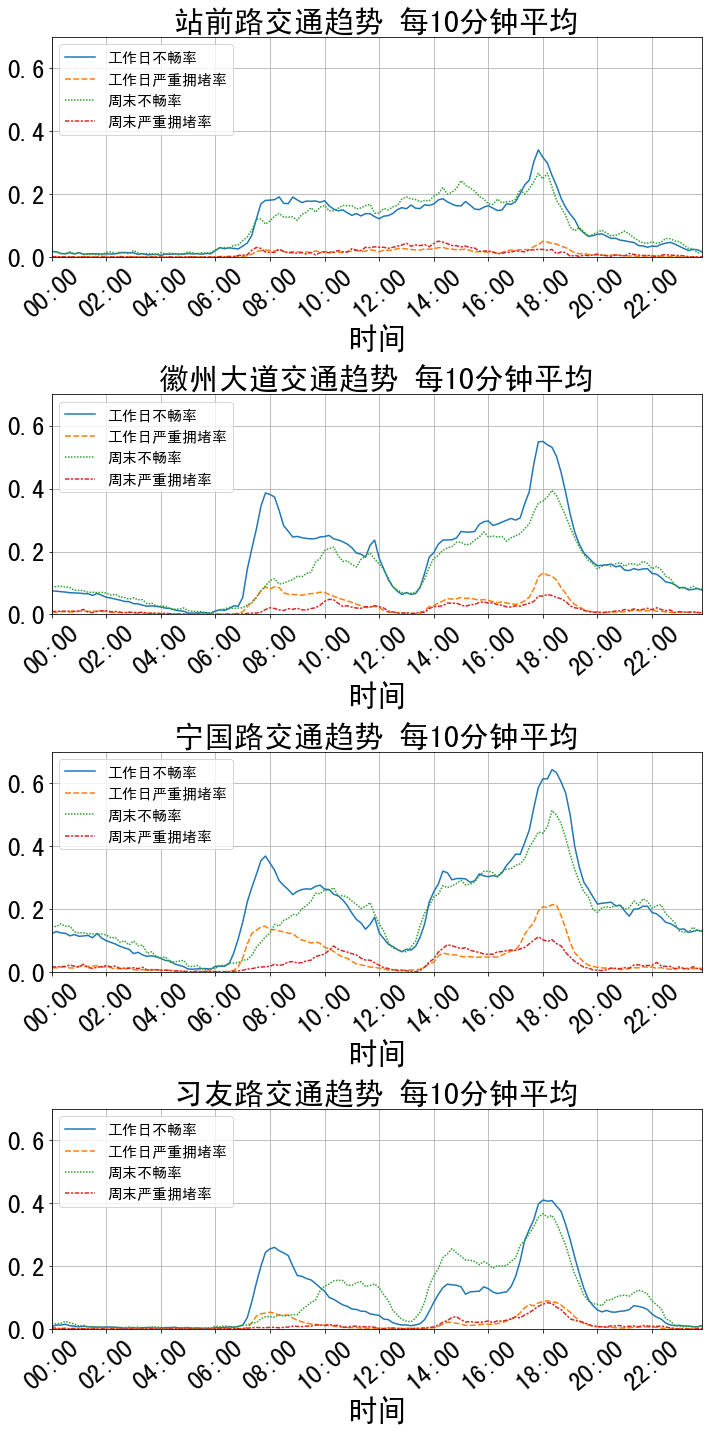

In [144]:
fig, ax = plt.subplots(4,1,figsize=(10, 20))
weekday_weekend_ten_min_plot(zhanqian, ax[0], '站前路交通趋势 每10分钟平均')
weekday_weekend_ten_min_plot(huizhou, ax[1], '徽州大道交通趋势 每10分钟平均')
weekday_weekend_ten_min_plot(ningguo, ax[2], '宁国路交通趋势 每10分钟平均')
weekday_weekend_ten_min_plot(xiyou, ax[3], '习友路交通趋势 每10分钟平均')
plt.tight_layout()

## Per hour Box plot
![Image of Box plot](https://chartio.com/images/tutorials/box-plot/boxplot1.png)
Although the last 4 plots gives good insights on the trand of traffic thoughout a day, it does not give good insights on the whole dataset beucause it is an average. In this box plot we are using the whole dataset we collected, thus can have more insights on the entire dataset.

First thing we oberse is that 5am is the most relax time on traffic, having 0 congestion for most of the time.

For 7am-9am, weekday's boxplots are shifted upward from weekends, meaning they are always more congested then weekends. Same thing happened to 5pm-6pm. (7pm doesn't have that big of a difference any more)

What's interesting is that over the weekends, 8pm-10pm there are more traffic in especially places near restaurants and shopping malls, for the reason discussed above (`Xiyou Rd`). The other way around, `Huizhou Ave`, one of the busiest road on people's way to work with less restaurants has much heavier traffic in 5-6pm on weekdays.

Another observation is that the shopping malls closes at around 11pm around `Xiyou Rd`, but most resuaurants / bars near `Ningguo Rd` opens all night. That could be why there is no traffic in `Xiyou Rd` after 11pm, but a fairly big congestion near `Ningguo Rd` around those times.

In [141]:
def hourly_boxplot(df, ax, title):
    """
    Produce hourly boxplot, separating weekdays and weekends
    :param DataFrame df: Traffic DataFrame used to plot
    :param plt.axis ax: Matplotlib axis to plot on
    :param str title: Plot title
    """
    df_hr = process_hour_group(df)
    sns.boxplot(x='hour', y='congestion', hue='isweekday', data=df_hr, ax=ax)
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.set_xlabel('小时')
    ax.set_ylabel('不畅率')
    # Set legend
    ax.legend(loc='upper left')
    leg = ax.get_legend()
    leg.set_title('日期类型')
    for t, l in zip(leg.texts, ['周末', '工作日']): t.set_text(l)

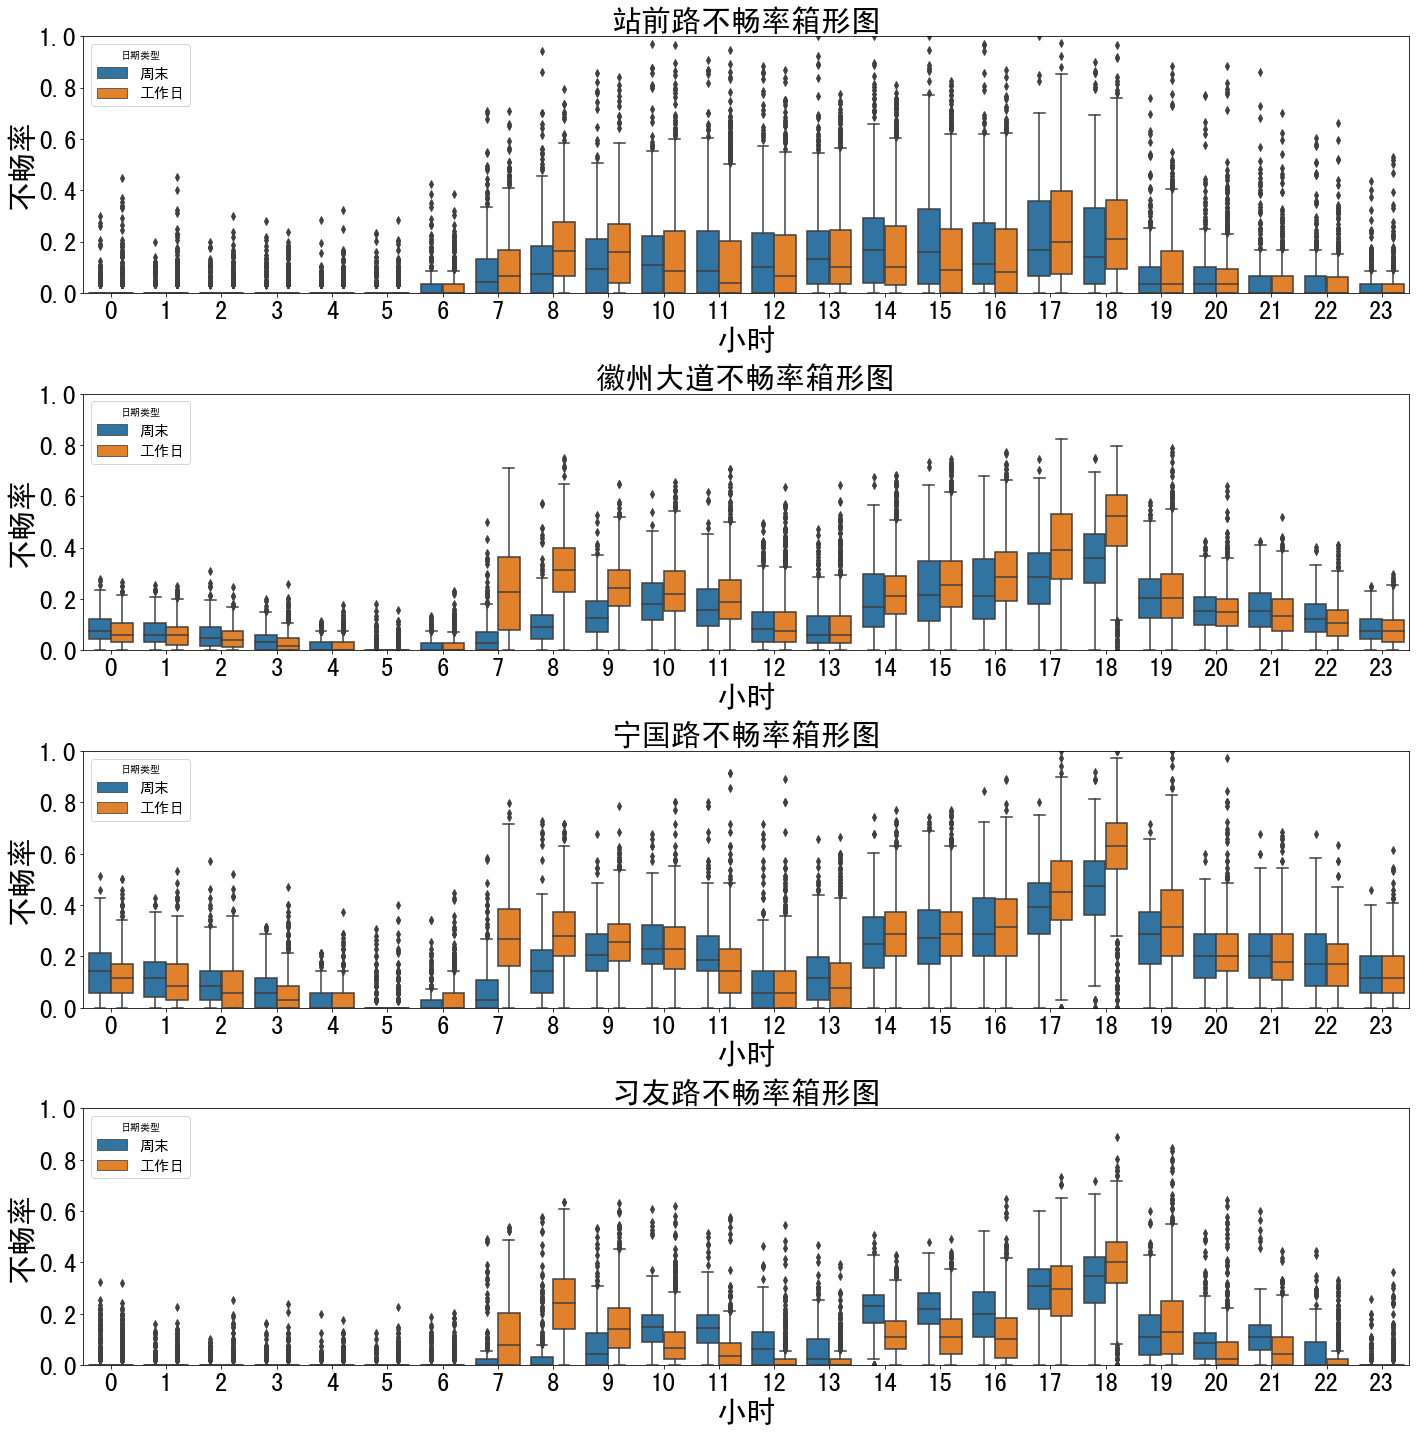

In [142]:
fig, axes = plt.subplots(4,1,figsize=(20,20))
hourly_boxplot(zhanqian, axes[0], '站前路不畅率箱形图')
hourly_boxplot(huizhou, axes[1], '徽州大道不畅率箱形图')
hourly_boxplot(ningguo, axes[2], '宁国路不畅率箱形图')
hourly_boxplot(xiyou, axes[3], '习友路不畅率箱形图')
plt.tight_layout()

## Violin plot for congestion % in a day
We've plotted the violin plot for the same data as above for a better visualization of the distribution.

From these distribution, the biggest thing we can gain is that in the morning, weekdays has a much more spread of congestion (standard deviation) in the morning, as compared to weekends. This might due to different days of week has different congestion condition in the morning.

For midnights, weekdays the congestion clusters more towards to 0, as compared to weekends. People tend to go out more on weekends instead of weekdays apparently.

In [132]:
def hourly_violinplot(df, ax, title):
    """
    Produce hourly violinplot, separting weekdays and weekends
    :param DataFrame df: Traffic DataFrame used to plot
    :param plt.axis ax: Matplotlib axis to plot on
    :param str title: Plot title
    """
    df_hr = process_hour_group(df)
    sns.violinplot(x='hour', y='congestion', hue='isweekday', data=df_hr, ax=ax, split=True)
    ax.set_ylim(0, 1)
    ax.set_xlabel('小时')
    ax.set_ylabel('不畅率')
    ax.set_title(title)
    # Set legend
    ax.legend(loc='upper left')
    leg = ax.get_legend()
    leg.set_title('日期类型')
    for t, l in zip(leg.texts, ['周末', '工作日']): t.set_text(l)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a

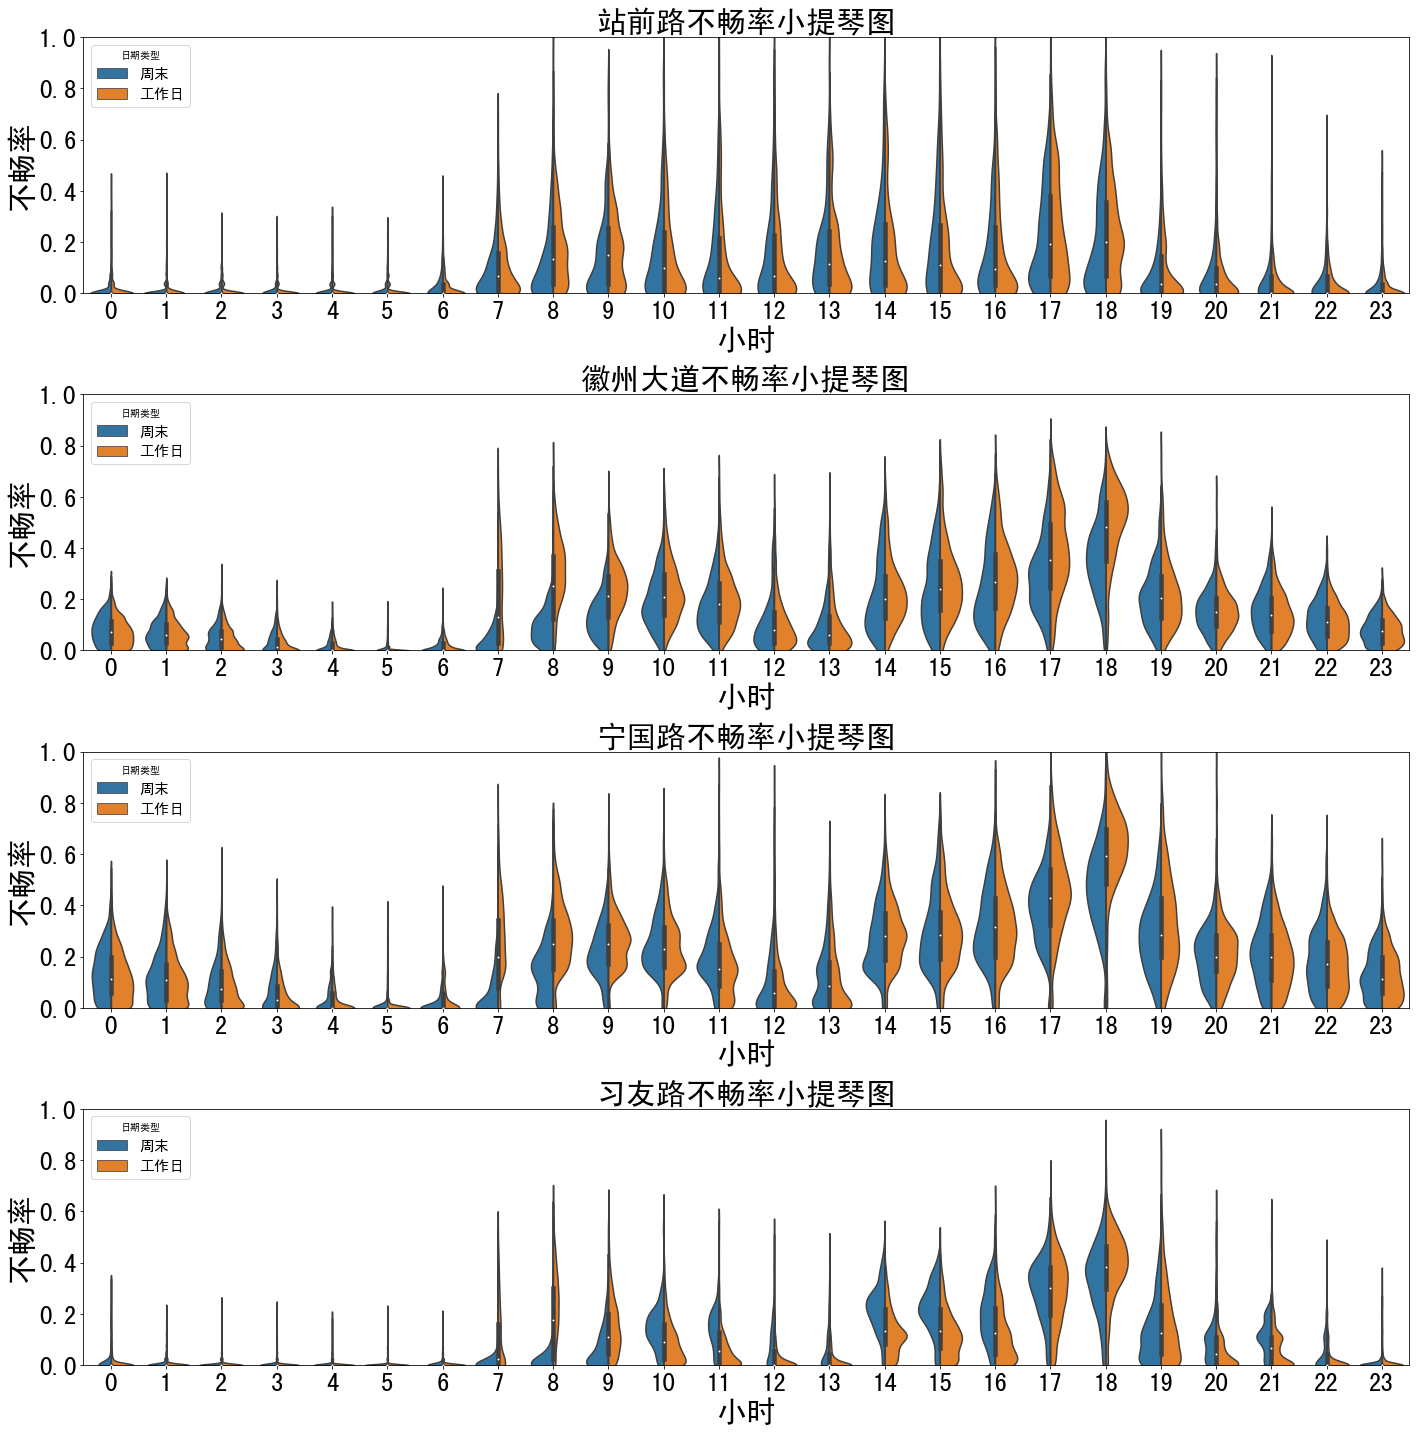

In [140]:
fig, axes = plt.subplots(4,1,figsize=(20,20))
hourly_violinplot(zhanqian, axes[0], '站前路不畅率小提琴图')
hourly_violinplot(huizhou, axes[1], '徽州大道不畅率小提琴图')
hourly_violinplot(ningguo, axes[2], '宁国路不畅率小提琴图')
hourly_violinplot(xiyou, axes[3], '习友路不畅率小提琴图')
plt.tight_layout()

# Connect Traffic with Weather
We obtained per hour rainfall amount (mm) data from Anhui Meteorological Bureau on stations near our 4 parts of the city. We will now try to find some relationship between the rain and traffic congestion.

The rainfall is measured in mm(millimeter) for every pass hour. We will classify them into 6:
- `0`: 0mm No rain
- `1`: 0.1-1mm Light Rain
- `2`: 1-5mm Heavy Rain
- `3`: 5-10mm Super Heavy Rain
- `4`: 10-20mm Flash Flood
- `5`: 20mm+ Super Flash Flood



In [6]:
zhanqian_rain = load_rain_data(os.getcwd() + '/data/rain_data.xlsx', 2)
huizhou_rain = load_rain_data(os.getcwd() + '/data/rain_data.xlsx', 3)
ningguo_rain = load_rain_data(os.getcwd() + '/data/rain_data.xlsx', 4)
xiyou_rain = load_rain_data(os.getcwd() + '/data/rain_data.xlsx', 5)

## Rainfall data overview
As we made a statistical count of the rainfall data, we find out there isn't that much recorded points of heavy rains in Hefei. Thus we might have trouble getting a solid conclusion on the cause of the rain.

In [7]:
rain_data_summary({'Zhanqian Rd': zhanqian_rain, 'Huizhou Ave': huizhou_rain,
                  'Ningguo Rd': ningguo_rain, 'Xiyou Rd': xiyou_rain})

Zhanqian Rd
0: 6870	1: 660	2: 164	3: 37	4: 12	5: 6	
Huizhou Ave
0: 6895	1: 582	2: 209	3: 30	4: 12	5: 7	
Ningguo Rd
0: 6189	1: 569	2: 145	3: 24	4: 11	5: 11	
Xiyou Rd
0: 7341	1: 244	2: 95	3: 18	4: 15	5: 5	


## Boxplot of impact to congestion by rain levels
As we see from the summary above, the incidence of heavy rain are relatively small to non rain, so we encountered difficulty to find a string correlation. There are many other reasons why there is a different amount of traffic for rainy days, including less people would like to go out during rainy days. All these different causes make it difficult to make a solid concludion.

However, some insights can still be inferred from the following plots. For rushing hours off work (5-7pm), it shows that the rain amount has a stronger relationship to traffic. A light and heavy rain generally makes more congestion. This could because that people already drive to work has to drive back, making them no choice on whether go out or not. They tend to drive slowly if the weather is bad, making more congestion.

In [145]:
def rain_level_boxplot(combined_data, ax, title):
    """
    Make a box plot comparing rain levels for every hour traffic congestion
    :param DataFrame combined_data: Processed DataFrame containing both traffic and rain data
    :param plt.axis ax: Matplotlib axis to plot on
    :param str title: Title for the plot
    """
    sns.boxplot(x='hour', y='congestion', hue='Rain Level', data=combined_data, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('小时')
    ax.set_ylabel('不畅率')
    ax.grid()
    leg = ax.get_legend()
    leg.set_title('降水大小')
    for t, l in zip(leg.texts, ['无降水', '0.1-1mm', '1-5mm', '5-10mm', '10-20mm', '20mm+']): t.set_text(l)

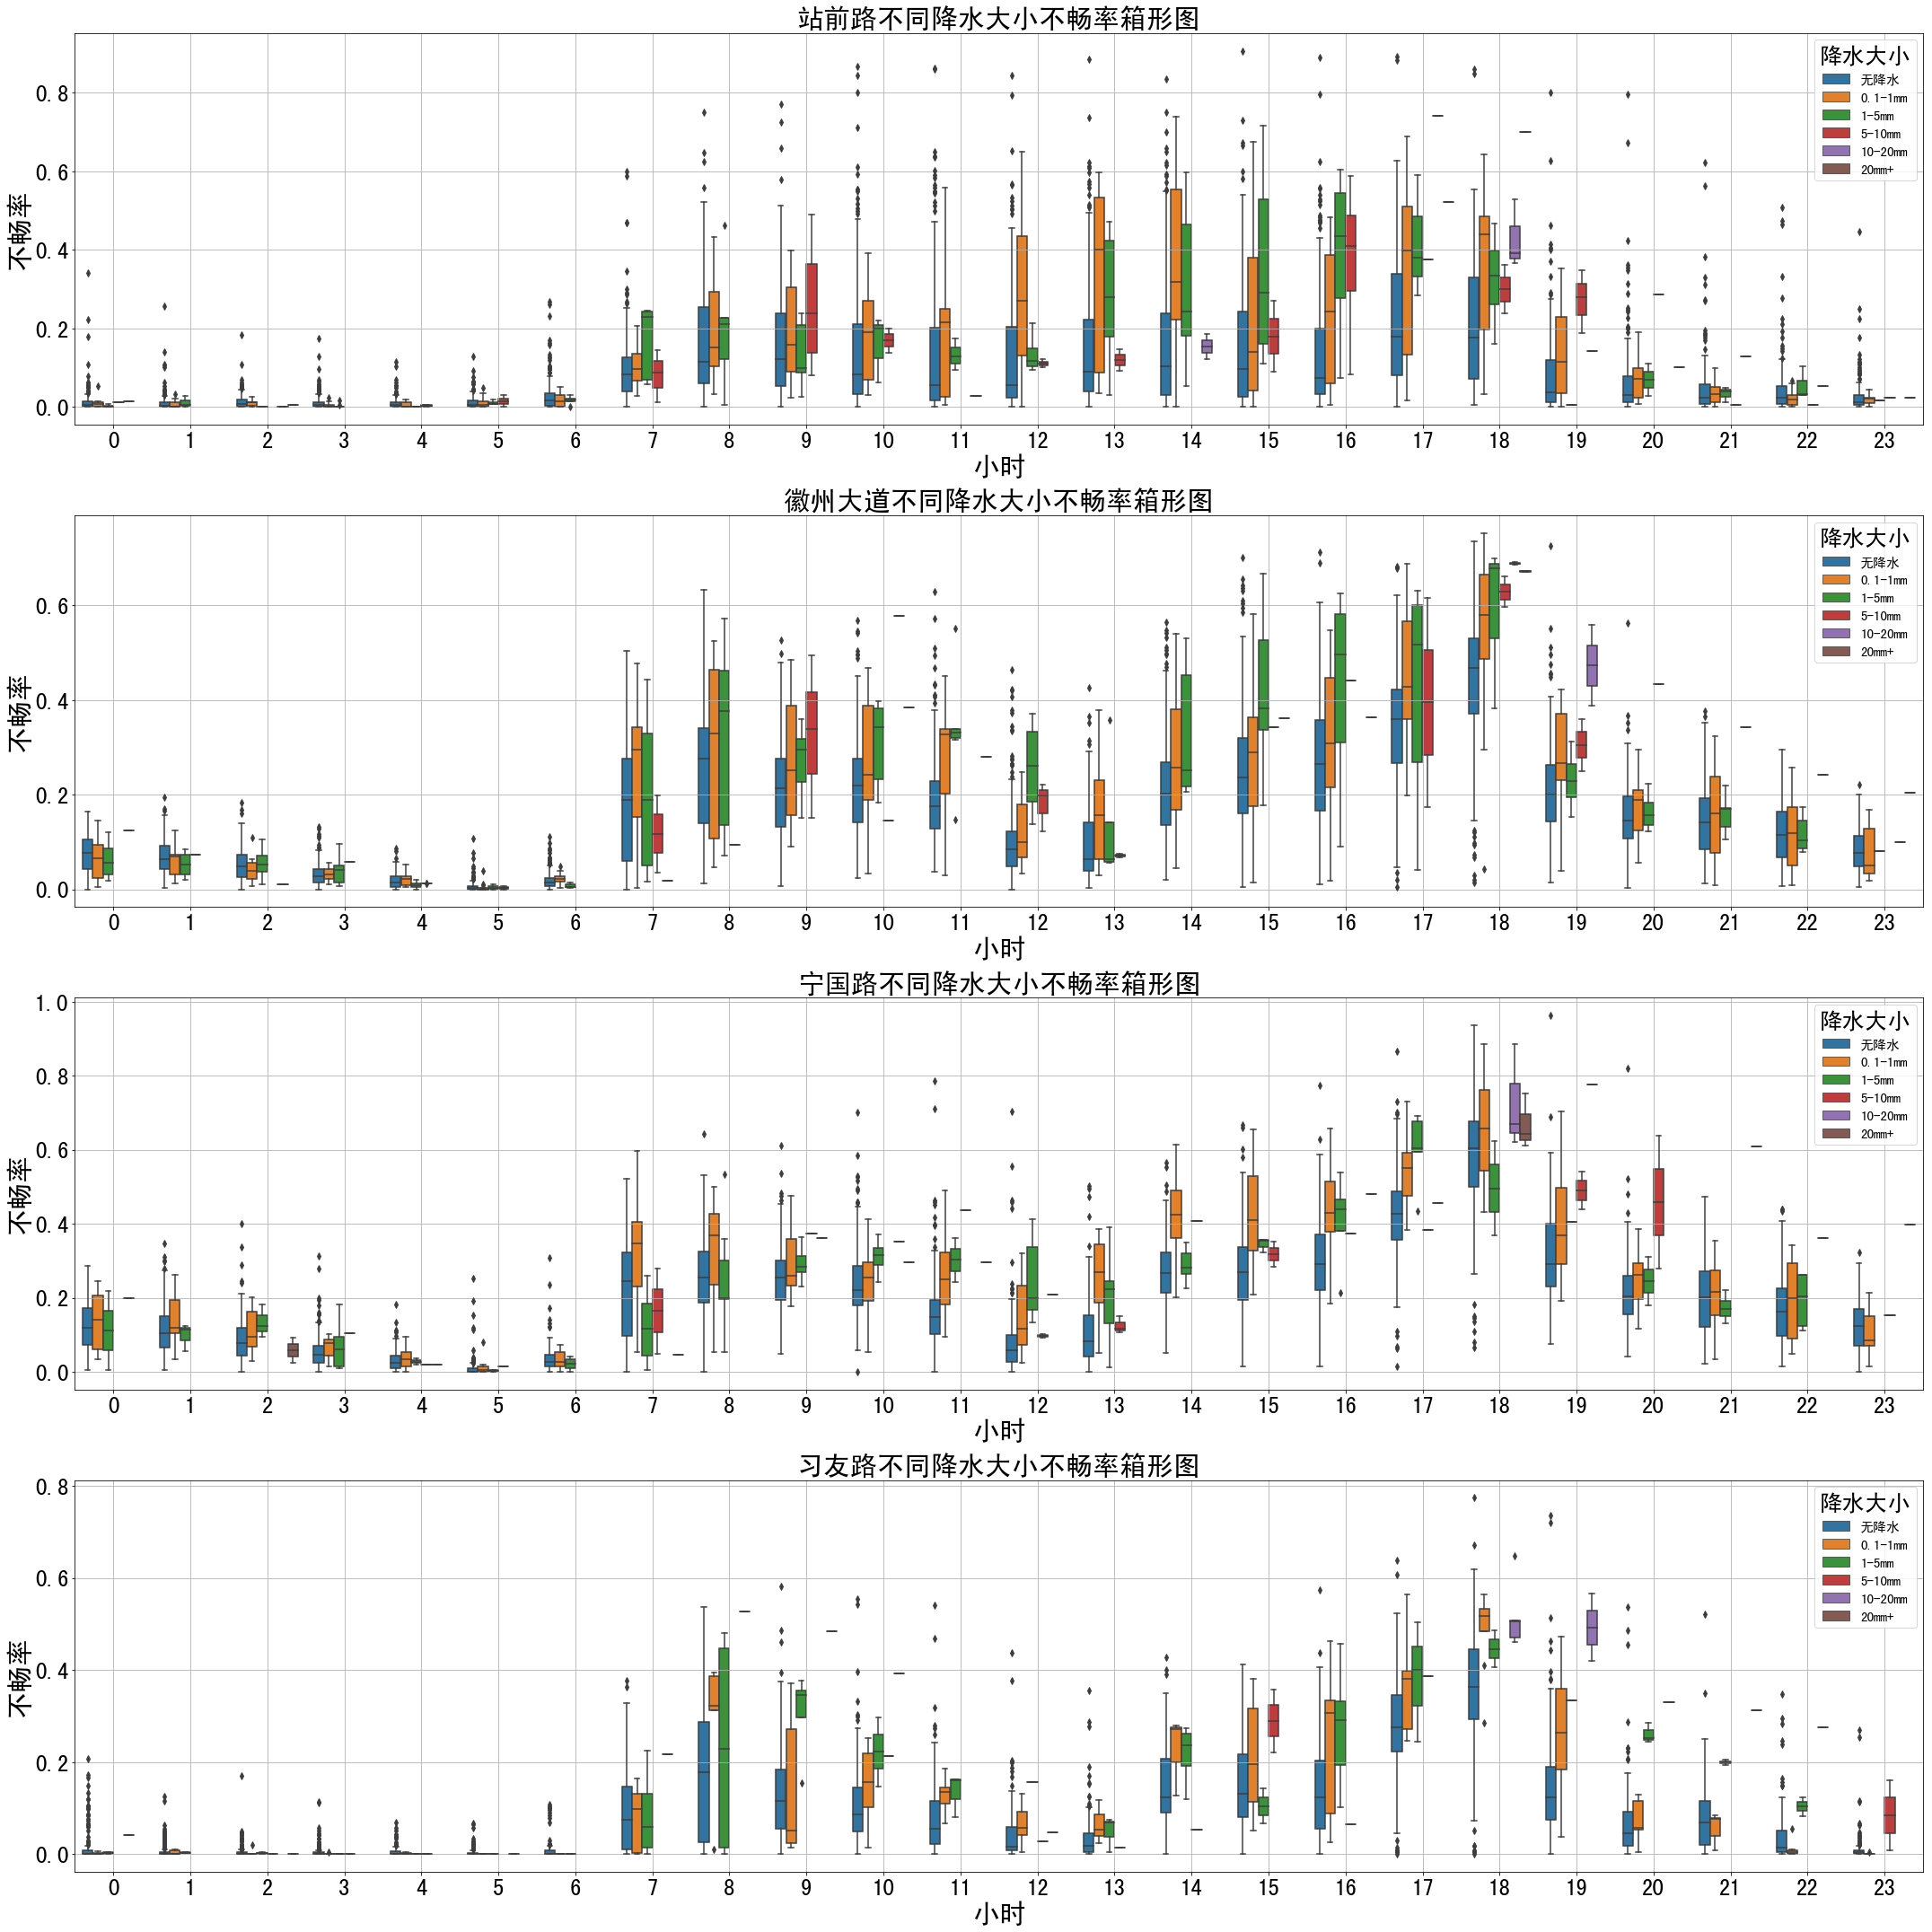

In [146]:
fig, ax = plt.subplots(4,1,figsize=(30,30))
zhanqian_combined = process_rain_data(zhanqian, zhanqian_rain)
huizhou_combined = process_rain_data(huizhou, huizhou_rain)
ningguo_combined = process_rain_data(ningguo, ningguo_rain)
xiyou_combined = process_rain_data(xiyou, xiyou_rain)
rain_level_boxplot(zhanqian_combined, ax[0], '站前路不同降水大小不畅率箱形图')
rain_level_boxplot(huizhou_combined, ax[1], '徽州大道不同降水大小不畅率箱形图')
rain_level_boxplot(ningguo_combined, ax[2], '宁国路不同降水大小不畅率箱形图')
rain_level_boxplot(xiyou_combined, ax[3], '习友路不同降水大小不畅率箱形图')
plt.tight_layout()

In [9]:
def process_influence(data, cong_col='congestion'):
    data = data[data['rain'] > 0]
    hr_avg = process_hour_avg(data)[cong_col]
    hour_avg = hr_avg[data['hour']]
    hour_avg.index = data.index
    data['Current Hour Avg'] = hour_avg
    data['Traffic influence'] = data[cong_col] - hour_avg
    return data

cong_col = 'congestion2'
zhanqian_infl = process_influence(zhanqian_combined, cong_col)
huizhou_infl = process_influence(huizhou_combined, cong_col)
ningguo_infl = process_influence(ningguo_combined, cong_col)
xiyou_infl = process_influence(xiyou_combined, cong_col)

data = pd.concat( [zhanqian_infl, huizhou_infl, ningguo_infl, xiyou_infl], axis=0) 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [10]:
data[data['rain'] == 17.7]
# data['Traffic influence'].sort_values()

,exp,cong,block,unknown,congestion,congestion2,heavy_congestion,rain,Rain Level,hour,Current Hour Avg,Traffic influence
date,,,,,,,,,,,,
2018-07-28 18:00:00,0.379755,0.474393,0.145855,0.000003,0.620251,0.766106,0.145855,17.7,4,18,0.87105,-0.104944


In [11]:
grey = [
        # Let first 10% (0.1) of the values have color rgb(0, 0, 0)
        [0, 'rgb(255, 255, 255)'], [0.1, 'rgb(255, 255, 255)'],
        [0.1, 'rgb(230, 230, 230)'], [0.2, 'rgb(230, 230, 230)'],
        [0.2, 'rgb(210, 210, 210)'], [0.3, 'rgb(210, 210, 210)'],
        [0.3, 'rgb(180, 180, 180)'], [0.4, 'rgb(180, 180, 180)'],
        [0.4, 'rgb(150, 150, 150)'], [0.5, 'rgb(150, 150, 150)'],
        [0.5, 'rgb(120, 120, 120)'], [0.6, 'rgb(120, 120, 120)'],
        [0.6, 'rgb(90, 90, 90)'], [0.7, 'rgb(90, 90, 90)'],
        [0.7, 'rgb(60, 60, 60)'], [0.8, 'rgb(60, 60, 60)'],
        [0.8, 'rgb(30, 30, 30)'], [0.9, 'rgb(30, 30, 30)'],
        [0.9, 'rgb(0, 0, 0)'], [1.0, 'rgb(0, 0, 0)']
]

# cs = 
# [
#         # Let first 10% (0.1) of the values have color rgb(0, 0, 0)
#         [0, 'rgb(0, 0, 0)'], [0.1, 'rgb(0, 0, 0)'],
#         [0.1, 'rgb(20, 20, 20)'], [0.2, 'rgb(20, 20, 20)'],
#         [0.2, 'rgb(40, 40, 40)'], [0.3, 'rgb(40, 40, 40)'],
#         [0.3, 'rgb(60, 60, 60)'], [0.4, 'rgb(60, 60, 60)'],
#         [0.4, 'rgb(80, 80, 80)'], [0.5, 'rgb(80, 80, 80)'],
#         [0.5, 'rgb(100, 100, 100)'], [0.6, 'rgb(100, 100, 100)'],
#         [0.6, 'rgb(120, 120, 120)'], [0.7, 'rgb(120, 120, 120)'],
#         [0.7, 'rgb(140, 140, 140)'], [0.8, 'rgb(140, 140, 140)'],
#         [0.8, 'rgb(160, 160, 160)'], [0.9, 'rgb(160, 160, 160)'],
#         [0.9, 'rgb(180, 180, 180)'], [1.0, 'rgb(180, 180, 180)']
# ]

In [12]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import numpy as np

trace1 = go.Scatter(
    x = data["rain"],
    y = data["Current Hour Avg"],
    mode='markers',
    marker=dict(
#         size = data['Traffic influence'] * 30 + 21,
        size = (data['Traffic influence'] + 0.7) * 20,
        color = data['Traffic influence'], #set color equal to a variable
#         colorscale='Jet',
        colorscale=grey,
        showscale=True
    )
)

iplot([trace1], filename='scatter-plot-with-colorscale')

In [13]:
zhanqian_rain_effect = process_rain(zhanqian, zhanqian_combined)
huizhou_rain_effect = process_rain(huizhou, huizhou_combined)
ningguo_rain_effect = process_rain(ningguo, ningguo_combined)
xiyou_rain_effect = process_rain(xiyou, xiyou_combined)

## Congestion difference from hourly average in different raining conditinon
As our further attempt to find more relationship between raining condition and traffic congestion, we calculated every sample's congestion difference to hourly average congestion, plotted the following scatter plot against how heavy it rains.

Since there are a lot of data spread out randonmly when raining between 0.1-1mm (light rain), we assumed such rain level doesn't affect traffic much, so we dropped those points from the plot. We are only plotting data when raining 1+ mm in the past hour. What we see from the plot is a general more congestion (difference is positive) for rain range around 5-20mm in the past hour. There are apparently more points at a higher positive difference in such rain range.

For rain less than 5mm in the past hour, the points are still distributed randomly, which doesn't give us more useful information.

For more heavy rains 20+ mm, although there are much less samples for us, we can see most of them are below the line (negative difference). This means it's actually less congested for flash flood hours. This could because people are unwilling to go out for such big rains, significantly decreased number of cars running on the road.

In [14]:
def cong_diff_scatter_plot(cong_diff_data, ax, title):
    """
    Produce the congestion difference in different raining condition scatter plot
    :param DataFrame cong_diff_data: DataFrame calculated by process_rain()
    :param plt.axis ax: Matplotlib axis to plot on
    :param str title: Title for the plot
    """
    from scipy.stats import linregress
    sns.scatterplot(x="rain", y="cong_diff", size="rain",hue="rain", data=cong_diff_data, ax=ax)
    slope, intercept, r_value, p_value, std_err = linregress(cong_diff_data["rain"],cong_diff_data["cong_diff"])
    print(f'{title}: Slope={slope}\tIntercept={intercept}\tR_Value={r_value}\tP_Value={p_value}\tStd_Err={std_err}')
    ax.axhline(y=0, color='black')
    ax.set_title(title)

Zhanqian Rd Congestion difference in different raining condition: Slope=0.0009764919787131525	Intercept=0.06413097239263765	R_Value=0.04791017767913835	P_Value=0.5423874397525679	Std_Err=0.0015995005065064696
Huizhou Ave Congestion difference in different raining condition: Slope=0.0023796495860487258	Intercept=0.05064443730287768	R_Value=0.1285300561105279	P_Value=0.09193250981697154	Std_Err=0.001404083802540096
Ningguo Rd Congestion difference in different raining condition: Slope=0.0028107910896037285	Intercept=0.033384729070241745	R_Value=0.20440431439071546	P_Value=0.01783369688480364	Std_Err=0.0011716122535794285
Xiyou Rd Congestion difference in different raining condition: Slope=0.006531390578954253	Intercept=0.040229969819787964	R_Value=0.3614186145777928	P_Value=0.00025581994596026353	Std_Err=0.0017197427677144957


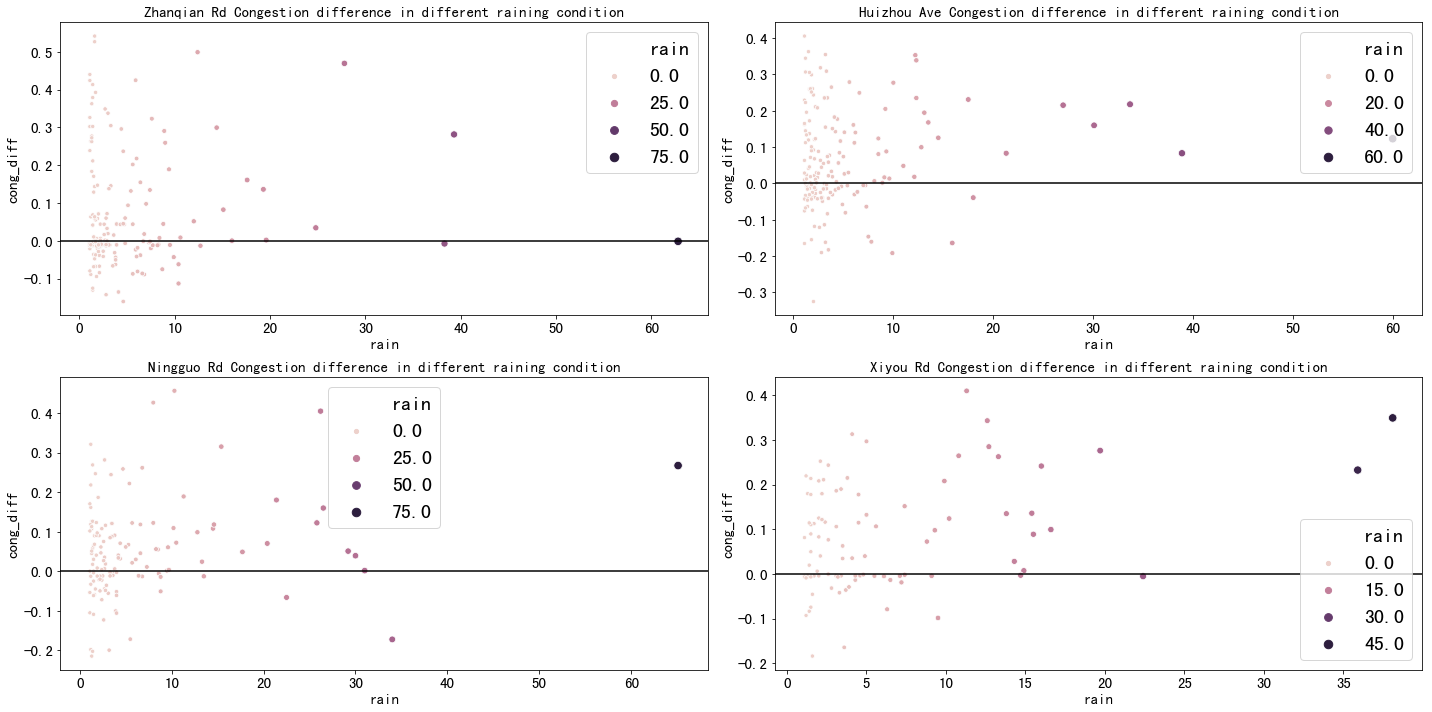

In [15]:
fig, axes = plt.subplots(2,2,figsize=(20,10))
cong_diff_scatter_plot(zhanqian_rain_effect, axes[0,0], 'Zhanqian Rd Congestion difference in different raining condition')
cong_diff_scatter_plot(huizhou_rain_effect, axes[0,1], 'Huizhou Ave Congestion difference in different raining condition')
cong_diff_scatter_plot(ningguo_rain_effect, axes[1,0], 'Ningguo Rd Congestion difference in different raining condition')
cong_diff_scatter_plot(xiyou_rain_effect, axes[1,1], 'Xiyou Rd Congestion difference in different raining condition')
plt.tight_layout()
# plt.savefig('cong_diff_scatter_plot.svg')

# Future Steps
We made a lot of insightful plots that we can make a good amount of insights. Since the limited in time for this project, some of them are not discussed thoroghly. Some future plans in improving this analysis includes:
- Try other matiematical calculations to fit the rain better to traffic congestion
- Try other kind of plots for a better data / relation visualization
- Collect traffic information in a city with much more rain incidents
- Improve the data collection script so that the data is more consistent
...